Roy Kleyder Maestre Ruda 2022

Dataset Image Colorization de Kaggle

Referencias:
https://www.kaggle.com/shravankumar9892/colorization-dataset/notebook

#### Para Local Runtime

Para correr local runtime usar los siguientes comandos en el anaconda prompt:

```
pip install jupyter_http_over_ws
```
```
jupyter serverextension enable --py jupyter_http_over_ws
```
```
jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0
```

#### Imports

In [ ]:
#Comenzamos descargando de mi drive el archivo kaggle.json para la identificacion en kaggle.
!gdown --id 1jh1BD7c_xxGFAaSWzM6h-6kGmvOyG2np

#Ahora instalamos Kaggle e identificamos el archivo kaggle.json
! pip install -q kaggle
! mkdir ~/.kaggle
! cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Descargamos el dataset y lo descomprimimos en una carpera llamada train
! kaggle datasets download -d shravankumar9892/image-colorization
! mkdir train
! unzip image-colorization.zip -d train

In [ ]:
! ls

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras
from IPython.display import Image
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

In [13]:
# Environment Variables
# Number of samples in the dataset
N = 5000
# DISMINUIR SI SE QUIERE CORRER EN COLAB, LA RAM DE COLAB VA A HACERLO FALLAR.

In [12]:
color_gray = np.load('train/l/gray_scale.npy')
color_lab = np.load('train/ab/ab/ab1.npy')
print(color_gray.shape, color_lab.shape)

(25000, 224, 224) (10000, 224, 224, 2) (10000, 224, 224, 2)


#### Setting up data

In [4]:
def recreate(gray_img, lab_img):
    """
    Adds gray and AB components into a printable image
    """
    img = np.zeros((224,224,3))
    img[:,:,0] = gray_img
    img[:,:,1:] = lab_img
    img = img.astype('uint8')
    img = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)
    return (gray_img, img)

def get_colors(gray_img, lab_img):
    """
    Adds gray and AB components into a printable image
    """
    img = np.zeros((224,224,3))
    img[:,:,0] = gray_img
    img[:,:,1:] = lab_img
    img = img.astype('uint8')
    img = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)
    return img

def get_lab(gray_img, lab_img):
    """
    Adds gray and AB components into a lab image
    """
    c = np.reshape(gray_img, (224,224,1))
    return np.concatenate((c,lab_img), axis=2)

def show_sample(n=False):
    """
    Prints random or a given sample in gray scale and recreated with LAB components
    """
    if not n: n = np.random.randint(0,500)
    img = recreate(color_gray[n],color_lab[n])

    fig = plt.figure(figsize=(10,5))
    fig.add_subplot(1,2,1).set_title("GrayScale")
    
    plt.imshow(img[0], cmap='gray')
    fig.add_subplot(1,2,2).set_title("Color")
    plt.imshow(img[1])
    plt.show()

In [14]:
def is_gray(image, threshold=0.025):
    """
    Identifies if an image is grayscale o almost grayscale
    """
    img = image.astype(int)
    diff = 0
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            rg = abs(img[i,j,0] - img[i,j,1])
            rb = abs(img[i,j,0] - img[i,j,2])
            gb = abs(img[i,j,1] - img[i,j,2])
            diff += rg + rb + gb
    ndiff = diff / (img.shape[0] * img.shape[1]) / (255 * 3);
    return ndiff < threshold 

def clean_bw(n, verbose=False):
    """
    Cleans all grayscaled images of the dataset. Returning n images arrays
    """
    m = n + 1
    for i in range(n):
        if is_gray(recreate(color_gray[i], color_lab[i])[1]):
            if verbose:
                show_sample(i)
                print('discarted', str(i))
            color_gray[i] = color_gray[m]
            color_lab[i] = color_lab[m]
            i -= 1
            m += 1
    print(f"Discarted {str(m-n-1)} samples")


def createY_lab(grays, colors, n=N):
    """
    Combines L and AB channels and returns an array of LAB images
    """
    y = np.zeros((n,224,224,3))
    for i in range(n):
        y[i,:,:,:] = get_lab(grays[i],colors[i])
    return y

def createY_rgb(grays, colors, n=N):
    """
    Combines L and AB channels and returns an array of RGB images
    """
    y = np.zeros((n,224,224,3))
    for i in range(n):
        y[i,:,:,:] = get_colors(grays[i],colors[i])
    return y


def recreate_lab(L,AB):
    """
    Combines L and AB channels and returns a LAB image
    """
    img = np.zeros((224,224,3))
    img[:,:,0] = L[:,:]
    img[:,:,1:] = AB
    return cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_LAB2RGB)

In [15]:
clean_bw(N)

Discarted 742 samples


In [16]:
#Now lets cut the size of the dataset to N, because the RAM given by colab can handles that many images.
test_gray = color_gray[7000:7500,:,:]
test_lab = color_lab[7000:7500,:,:,:]
color_gray = color_gray[0:N,:,:]    #Let's take only 5k samples
color_lab = color_lab[0:N,:,:,:]
print(f"Train L {color_gray.shape}, Train AB {color_lab.shape} \nTest L{test_gray.shape}, Test AB{test_lab.shape}")

Train L (5000, 224, 224), Train AB (5000, 224, 224, 2) 
Test L(500, 224, 224), Test AB(500, 224, 224, 2)


In [17]:
XTrain = createY_rgb(color_gray,color_lab)/255

In [18]:
X_Train, X_Val = train_test_split(XTrain, test_size=.2)

In [34]:
import gc
del(color_gray)
del(color_lab)
del(XTrain)
gc.collect()

28977

#### InceptionResNetV2 preparation

In [ ]:
!pip install keras_applications

     -------------------------------------- 50.7/50.7 KB 642.3 kB/s eta 0:00:00


In [24]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.compat.v1 import get_default_graph
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Dropout, Input, Conv2D, MaxPool2D, UpSampling2D, RepeatVector, Reshape, concatenate, AveragePooling2D, Flatten

In [26]:
inception = InceptionResNetV2(weights='imagenet', include_top=True)
inception.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
________________________________________________________________________________

In [ ]:
# Testing predictions

def predict_inception(imgs):
    imgs_rgb_resized = []
    for i in imgs:
        i = cv2.resize(i, (299, 299))
        imgs_rgb_resized.append(i)
    imgs_rgb_resized = np.array(imgs_rgb_resized)
    #imgs_rgb_resized = preprocess_input(imgs_rgb_resized)
    pred = inception.predict(imgs_rgb_resized)
    return pred

# DESCOMENTAR SI SE QUIERE VER EL RESULTADOS DE LAS PREDICCIONES DE INCEPTIONRESTNETV2
#preds = predict_inception(XTrain[:20])

#for i in range(20):
    #print(np.argmax(preds[i]))
    #plt.imshow(XTrain[i])
    #plt.show()

#### Model

In [27]:
def get_model():  
    
    inception_input = Input(shape=(1000,))

    #Encoder
    encoder_input = Input(shape=(224,224,1))
    encoder_output = Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(encoder_input)
    encoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
    encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
    encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)

    #Inception Layers
    inception_output = RepeatVector(28*28)(inception_input)
    inception_output = Reshape(([28,28,1000]))(inception_output)
    inception_output = concatenate([encoder_output, inception_output], axis=3)
    inception_output = Conv2D(256, (1,1), activation='relu', padding='same')(inception_output)

    #Decoder
    decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(inception_output)
    decoder_output = UpSampling2D((2, 2))(decoder_output)
    decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
    decoder_output = UpSampling2D((2, 2))(decoder_output)
    decoder_output = Conv2D(32, (3,3), activation='relu', padding='same')(decoder_output)
    decoder_output = Conv2D(32, (3,3), activation='relu', padding='same')(decoder_output)
    decoder_output = Dropout(0.2)(decoder_output)
    decoder_output = Conv2D(16, (3, 3), activation='relu', padding='same')(decoder_output)
    decoder_output = Dropout(0.2)(decoder_output)
    decoder_output = UpSampling2D((2, 2))(decoder_output)
    decoder_output = Conv2D(8, (3, 3), activation='relu', padding='same')(decoder_output)
    decoder_output = Conv2D(3, (3, 3), activation='tanh', padding='same')(decoder_output)

    model = Model(inputs=[encoder_input, inception_input], outputs=decoder_output)    
    model.compile(optimizer='adam', loss='mse', metrics=['acc'])
    return model

In [29]:
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb

def create_inception_embedding(imgs_rgb):
    imgs_rgb_resized = []
    for i in imgs_rgb:
        i = cv2.resize(i, (299, 299))
        imgs_rgb_resized.append(i)
    imgs_rgb_resized = np.array(imgs_rgb_resized)
    embed = inception.predict(imgs_rgb_resized)
    return embed

# Image transformer
datagen = ImageDataGenerator(rotation_range=10,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              shear_range=0.1,
                              zoom_range=0.1,
                              fill_mode="nearest"
                              )

#Generate training data

def image_gen(X_train, batch_size):
    for batch in datagen.flow(X_train, batch_size=batch_size):
        X_batch = np.zeros((batch_size, 224,224,1))
        X_batch[:,:,:,0] = rgb2lab(batch)[:,:,:,0]
        Y_batch = np.zeros((batch_size, 224,224,2))
        Y_batch = batch
        rgb = np.zeros((batch_size, 224,224,3))
        embeb = create_inception_embedding(batch)
                
        yield([X_batch, embeb], Y_batch)


In [30]:
model = get_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
conv2d_203 (Conv2D)             (None, 112, 112, 64) 640         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_204 (Conv2D)             (None, 112, 112, 128 73856       conv2d_203[0][0]                 
__________________________________________________________________________________________________
conv2d_205 (Conv2D)             (None, 56, 56, 128)  147584      conv2d_204[0][0]                 
______________________________________________________________________________________________

In [31]:
from keras.callbacks import ModelCheckpoint

# Por si pasa algo malo y se interrumpe el entranamiento
my_checkpointer = [
                ModelCheckpoint(filepath="model3.2_chekcpoint.h5", verbose=1, save_weights_only=True)
                ]

#### Training

Empiezo a las 4:40pm

In [35]:
BATCH_SIZE = 20
EPOCHS = 120

##DISMINUIR EPOCAS SI NO QUIERE TARDAR HORAS

results = model.fit(image_gen(X_Train, BATCH_SIZE), 
                    epochs=EPOCHS, 
                    steps_per_epoch=(X_Train.shape[0]//BATCH_SIZE), 
                    callbacks=my_checkpointer,
                    validation_data=image_gen(X_Val, BATCH_SIZE), 
                    validation_steps=X_Val.shape[0] // BATCH_SIZE)

Epoch 1/120
200/200 [==============================] - 103s 518ms/step - loss: 0.0168 - acc: 0.5227 - val_loss: 0.0144 - val_acc: 0.5669

Epoch 00001: saving model to model3.2_chekcpoint.h5
Epoch 2/120
200/200 [==============================] - 104s 523ms/step - loss: 0.0148 - acc: 0.5207 - val_loss: 0.0135 - val_acc: 0.5544

Epoch 00002: saving model to model3.2_chekcpoint.h5
Epoch 3/120
200/200 [==============================] - 104s 521ms/step - loss: 0.0142 - acc: 0.5162 - val_loss: 0.0134 - val_acc: 0.5185

Epoch 00003: saving model to model3.2_chekcpoint.h5
Epoch 4/120
200/200 [==============================] - 104s 523ms/step - loss: 0.0136 - acc: 0.5285 - val_loss: 0.0130 - val_acc: 0.5625

Epoch 00004: saving model to model3.2_chekcpoint.h5
Epoch 5/120
200/200 [==============================] - 105s 525ms/step - loss: 0.0136 - acc: 0.5383 - val_loss: 0.0126 - val_acc: 0.5519

Epoch 00005: saving model to model3.2_chekcpoint.h5
Epoch 6/120
200/200 [=============================

Terminó a las 8:07pm

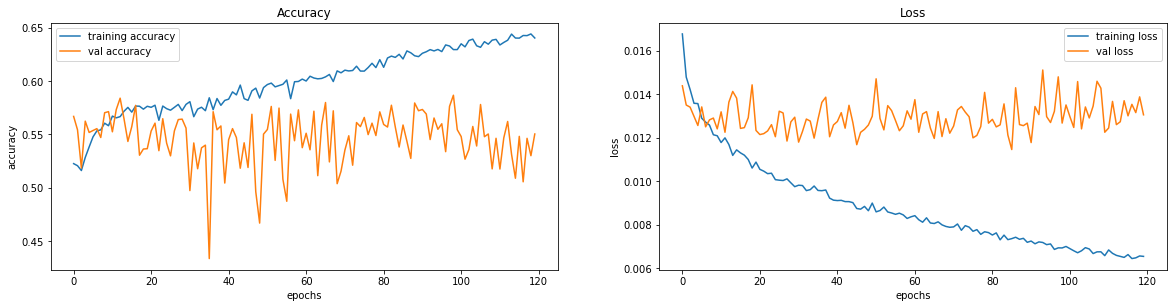

In [38]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(20,10))
grid=gridspec.GridSpec(ncols=2,nrows=2,figure=fig)
fig.add_subplot(grid[0])
plt.plot(results.history['acc'], label='training accuracy')
plt.plot(results.history['val_acc'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

fig.add_subplot(grid[1])
plt.plot(results.history['loss'], label='training loss')
plt.plot(results.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

#### Preparing tests
Run just the first time

In [39]:
color_gray = np.load('train/l/gray_scale.npy')
color_lab = np.load('train/ab/ab/ab1.npy')

test_gray = color_gray[1800:1900]
test_lab = color_lab[1800:1900]

Y_test = createY_rgb(test_gray,test_lab,100)/255

X_test = np.zeros((Y_test.shape[0], 224,224,1))
X_test[:,:,:,0] = rgb2lab(Y_test)[:,:,:,0]

color_me_embed = create_inception_embedding(Y_test)

# Test model
output = model.predict([X_test, color_me_embed])
X_pred = (output * 255).astype('uint8')


In [ ]:
def recreate_lab(L,AB):
    img = np.zeros((224,224,3))
    img[:,:,0] = L[:,:,0]*255
    img[:,:,1:] = AB*255
    return cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_LAB2RGB)

In [41]:
def show_result_samples():
    """
    Prints random or a given sample in gray scale and recreated with LAB components
    """

    for i in range(X_test.shape[0]):
        fig = plt.figure(figsize=(15,5))

        fig.add_subplot(1,3,1).set_title("GrayScale")    
        plt.imshow(X_test[i][:,:,0], cmap='gray')

        fig.add_subplot(1,3,2).set_title("Color")
        plt.imshow(Y_test[i])

        fig.add_subplot(1,3,3).set_title("Predicted")
        plt.imshow(X_pred[i])

        plt.show()

#### Running test samples
Run every time you test

In [42]:
show_result_samples()

Output hidden; open in https://colab.research.google.com to view.

#### Save model

In [45]:
model_json = model.to_json()
with open("train/models/LAB2.1/ImageColorized_3.2_Model.json", "w") as json_file:
  json_file.write(model_json)
model.save_weights('train/models/LAB2.1/ImageColorized_3.2_Model')